**Dependencies and setup**

This can take a minute or so...

In [1]:
# This code is based on:
# Nikile Barhat. TD3-BipedalWalker-v2-PyTorch. url: https://github.com/nikhilbarhate99/TD3-PyTorch-BipedalWalker-v2. (accessed: 09.02.2022)
# released under the MIT liscence
# and:
# Honghao Wei and Lei Ying. FORK. url: https://github.com/honghaow/FORK. (accessed: 09.02.2022). released under the MIT liscence

%%capture

!pip install 'gym[box2d]'
!apt update
!apt install xvfb -y
!pip install pyvirtualdisplay

import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
from pyvirtualdisplay import Display
from IPython import display as disp
%matplotlib inline

display = Display(visible=0,size=(600,600))
display.start()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

plot_interval = 10 # update the plot every N episodes
video_every = 50 # videos can take a very long time to render so only do it every N episodes

In [2]:
# optional Google drive integration - this will allow you to save and resume training, and may speed up redownloading the dataset
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**Replay Buffer**

In [3]:
class ReplayBuffer:
    def __init__(self, max_size=1e6):
        self.buffer = []
        self.max_size = int(max_size)
        self.size = 0
    
    def add(self, transition):
        self.size +=1
        # transiton is tuple of (state, action, reward, next_state, done)
        self.buffer.append(transition)
    
    def sample(self, batch_size):
        # delete 1/5th of the buffer when full
        if self.size > self.max_size:
            del self.buffer[0:int(self.size/5)]
            self.size = len(self.buffer)
        
        indexes = np.random.randint(0, len(self.buffer), size=batch_size)
        state, action, reward, next_state, done = [], [], [], [], []
        
        for i in indexes:
            s, a, r, s_, d = self.buffer[i]
            state.append(np.array(s, copy=False))
            action.append(np.array(a, copy=False))
            reward.append(np.array(r, copy=False))
            next_state.append(np.array(s_, copy=False))
            done.append(np.array(d, copy=False))
        
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)

**Reinforcement learning agent**

In [4]:
class Actor(nn.Module):
    #takes a state and outputs the action with the highest Q score
    def __init__(self, state_dim, action_dim, max_action): 
        super(Actor, self).__init__()
        
        self.l1 = nn.Linear(state_dim, 256) 
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, action_dim)
        
        self.max_action = max_action
        
    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        a = torch.tanh(self.l3(a)) * self.max_action
        return a


class Critic(nn.Module):
    #takes state-action pair and outputs a Q score
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        
        self.l1 = nn.Linear(state_dim + action_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 1)
        
    def forward(self, state, action):
        state_action = torch.cat([state, action], 1)
        
        q = F.relu(self.l1(state_action))
        q = F.relu(self.l2(q))
        q = self.l3(q)
        return q


class SystemNet(nn.Module):
    # takes a state-action pair and predicts the next state
    def __init__(self, state_size, action_size):
        super(SystemNet, self).__init__()
        self.l1 = nn.Linear(state_size + action_size, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, state_size)

    def forward(self, state, action):
        xa = torch.cat([state, action], 1)

        x1 = F.relu(self.l1(xa))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)
        return x1


class RewardNet(nn.Module):
    #takes a takes a state-action pair and the next state (st, at, st+1) and predicts the reward given
    def __init__(self, state_dim, action_dim):
        super(RewardNet, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(2 * state_dim + action_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 1)

    def forward(self, state,next_state, action):
        sa = torch.cat([state, next_state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)
        return q1


class TD3:
    def __init__(self, lr, state_dim, action_dim, max_action):
        
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        
        self.critic_1 = Critic(state_dim, action_dim).to(device)
        self.critic_1_target = Critic(state_dim, action_dim).to(device)
        self.critic_1_target.load_state_dict(self.critic_1.state_dict())
        self.critic_1_optimizer = optim.Adam(self.critic_1.parameters(), lr=lr)
        
        self.critic_2 = Critic(state_dim, action_dim).to(device)
        self.critic_2_target = Critic(state_dim, action_dim).to(device)
        self.critic_2_target.load_state_dict(self.critic_2.state_dict())
        self.critic_2_optimizer = optim.Adam(self.critic_2.parameters(), lr=lr)

        self.system_net = SystemNet(state_dim, action_dim).to(device)
        self.system_net_optimizer = optim.Adam(self.system_net.parameters(), lr=lr)
        self.system_net.apply(self.init_weights)

        self.reward_net = RewardNet(state_dim, action_dim).to(device)
        self.reward_net_optimizer = torch.optim.Adam(self.reward_net.parameters(), lr=lr)

        self.max_action = max_action
        self.tot_updates = 0
    
    def init_weights(self,m):
        # xavier initialisation for weights of system network
        if type(m) == nn.Linear:
          torch.nn.init.xavier_uniform_(m.weight)
          m.bias.data.fill_(0.001)
        
    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()
    
    def update(self, replay_buffer, n_iter, batch_size, gamma, polyak, policy_noise, noise_clip, policy_delay, obs_upper_bound, obs_lower_bound, 
               sys_threshold, sys_weight):
        
        for i in range(n_iter):
            self.tot_updates += 1
            # Sample a batch of transitions from replay buffer:
            state, action_, reward, next_state, done = replay_buffer.sample(batch_size)
            state = torch.FloatTensor(state).to(device)
            action = torch.FloatTensor(action_).to(device)
            reward = torch.FloatTensor(reward).reshape((batch_size,1)).to(device)
            next_state = torch.FloatTensor(next_state).to(device)
            done = torch.FloatTensor(done).reshape((batch_size,1)).to(device)
            
            # Select next action according to target policy:
            noise = torch.FloatTensor(action_).data.normal_(0, policy_noise).to(device)
            noise = noise.clamp(-noise_clip, noise_clip)
            next_action = (self.actor_target(next_state) + noise)
            next_action = next_action.clamp(-self.max_action, self.max_action)
            
            # Compute target Q-value:
            target_Q1 = self.critic_1_target(next_state, next_action)
            target_Q2 = self.critic_2_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + ((1-done) * gamma * target_Q).detach()
            
            # Optimize Critic 1:
            current_Q1 = self.critic_1(state, action)
            loss_Q1 = F.mse_loss(current_Q1, target_Q)
            self.critic_1_optimizer.zero_grad()
            loss_Q1.backward()
            self.critic_1_optimizer.step()
            
            # Optimize Critic 2:
            current_Q2 = self.critic_2(state, action)
            loss_Q2 = F.mse_loss(current_Q2, target_Q)
            self.critic_2_optimizer.zero_grad()
            loss_Q2.backward()
            self.critic_2_optimizer.step()

            # Train system net
            predict_next_state = self.system_net(state, action)
            predict_next_state = predict_next_state.clamp(obs_lower_bound, obs_upper_bound) # make sure state prediction is within state space
            system_net_loss = F.smooth_l1_loss(predict_next_state, next_state.detach())
            self.system_net_optimizer.zero_grad()
            system_net_loss.backward()
            self.system_net_optimizer.step()
            self.system_net_loss = system_net_loss.item()

            s_flag = 1 if system_net_loss.item() < sys_threshold else 0

            # Train reward net
            predict_reward = self.reward_net(state, next_state, action)
            reward_net_loss = F.mse_loss(predict_reward, reward.detach())            
            self.reward_net_optimizer.zero_grad()
            reward_net_loss.backward()
            self.reward_net_optimizer.step()
            self.reward_net_loss = reward_net_loss.item()

            # Delayed policy updates:
            if self.tot_updates % policy_delay == 0:
                # Compute actor loss:
                actor_loss1 = -self.critic_1(state, self.actor(state)).mean()

                # if system model loss below the system threshold use predicted future states and rewards to help train the actor
                if s_flag == 1:
                    # Predict the next state and action that would be taken in this state
                    p_next_state = self.system_net(state, self.actor(state))
                    p_next_state = p_next_state.clamp(obs_lower_bound, obs_upper_bound)
                    actions2 = self.actor(p_next_state.detach())

                    # Predict the reward given this
                    p_next_r = self.reward_net(state, p_next_state.detach(), self.actor(state))
                    
                    # Repeat to get state and reward of st+2
                    p_next_state2 = self.system_net(p_next_state, self.actor(p_next_state.detach()))
                    p_next_state2 = p_next_state2.clamp(obs_lower_bound, obs_upper_bound)
                    p_next_r2 = self.reward_net(p_next_state.detach(), p_next_state2.detach(), self.actor(p_next_state.detach()))
                    actions3 = self.actor(p_next_state2.detach())

                    # Calculate actor loss
                    actor_loss2 =  self.critic_1(p_next_state2.detach(), actions3)
                    actor_loss3 =  -(p_next_r + gamma * p_next_r2 + gamma ** 2 * actor_loss2).mean()
                
                    actor_loss = (actor_loss1 + sys_weight * actor_loss3)

                else:
                    actor_loss = actor_loss1
                
                # Optimize the actor
                self.critic_1_optimizer.zero_grad()
                self.critic_2_optimizer.zero_grad()
                self.system_net_optimizer.zero_grad()
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()
                
                # Polyak averaging update:
                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))
                
                for param, target_param in zip(self.critic_1.parameters(), self.critic_1_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))
                
                for param, target_param in zip(self.critic_2.parameters(), self.critic_2_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))
            
                        
    def save(self, directory, name):
        torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, name))
        torch.save(self.actor_target.state_dict(), '%s/%s_actor_target.pth' % (directory, name))
        
        torch.save(self.critic_1.state_dict(), '%s/%s_crtic_1.pth' % (directory, name))
        torch.save(self.critic_1_target.state_dict(), '%s/%s_critic_1_target.pth' % (directory, name))
        
        torch.save(self.critic_2.state_dict(), '%s/%s_crtic_2.pth' % (directory, name))
        torch.save(self.critic_2_target.state_dict(), '%s/%s_critic_2_target.pth' % (directory, name))

        torch.save(self.system_net.state_dict(), '%s/%s_system_net.pth' % (directory, name))
        
        torch.save(self.reward_net.state_dict(), '%s/%s_reward_net.pth' % (directory, name))
        
    def load(self, directory, name):
        self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, name), map_location=lambda storage, loc: storage))
        self.actor_target.load_state_dict(torch.load('%s/%s_actor_target.pth' % (directory, name), map_location=lambda storage, loc: storage))
        
        self.critic_1.load_state_dict(torch.load('%s/%s_crtic_1.pth' % (directory, name), map_location=lambda storage, loc: storage))
        self.critic_1_target.load_state_dict(torch.load('%s/%s_critic_1_target.pth' % (directory, name), map_location=lambda storage, loc: storage))
        
        self.critic_2.load_state_dict(torch.load( '%s/%s_crtic_2.pth' % (directory, name), map_location=lambda storage, loc: storage))
        self.critic_2_target.load_state_dict(torch.load('%s/%s_critic_2_target.pth' % (directory, name), map_location=lambda storage, loc: storage))

        self.system_net.load_state_dict(torch.load('%s/%s_system_net.pth' % (directory, name), map_location=lambda storage, loc: storage))

        self.reward_net.load_state_dict(torch.load('%s/%s_reward_net.pth' % (directory, name), map_location=lambda storage, loc: storage))

**Prepare the environment and wrap it to capture videos**

In [5]:
%%capture
env_name = "BipedalWalker"
if env_name == "BipedalWalker":
    env = gym.make("BipedalWalker-v3")
    max_reward = 320
elif env_name == "Pendulum":
    env = gym.make("Pendulum-v0") # useful continuous environment for quick experiments
    max_reward = -16.2736044
elif env_name == "BipedalWalkerHardcore":
    env = gym.make("BipedalWalkerHardcore-v3") # only attempt this if your agent consistently aces BipedalWalker-v3
    max_reward = 320

env = gym.wrappers.Monitor(env, "./video", video_callable=lambda ep_id: ep_id%video_every == 0, force=True)

obs_dim = env.observation_space.shape[0] #aka state dimensions
act_dim = env.action_space.shape[0]
act_max = float(env.action_space.high[0])
obs_upper_bound = float(env.observation_space.high[0]) #state space upper bound
obs_lower_bound = float(env.observation_space.low[0])  #state space lower bound
if obs_upper_bound == float('inf'):
			obs_upper_bound, obs_lower_bound = 0, 0

In [6]:
print('The environment has {} observations and the agent can take {} actions'.format(obs_dim, act_dim))
print('The device is: {}'.format(device))

if device.type != 'cpu': print('It\'s recommended to train on the cpu for this')

The environment has 24 observations and the agent can take 4 actions
The device is: cuda
It's recommended to train on the cpu for this


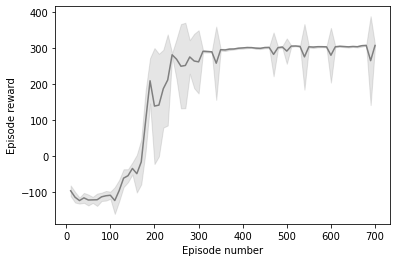

In [7]:
from numpy.core.numeric import False_
# in the submission please use seed 42 for verification
seed = 42
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

# logging variables
ep_reward = 0
reward_list = []
plot_data = []
log_f = open("agent-log.txt","w+")
tot_timesteps = 0
total_reward_list = []
flag = False

# initialise agent
reward_lower_bound = 0
reward_upper_bound = 0
sys_weight = 0.5
sys_weight2 = 0.4
sys_threshold = 0.010
base_weight = 0.6

max_episodes = 701
max_timesteps = 2000
gamma = 0.99                  # discount for future rewards
batch_size = 100              # num of transitions sampled from replay buffer
lr = 3e-4 #lr = 0.001
exploration_noise = 0.1 
polyak = 0.995                # target policy update parameter 
policy_noise = 0.2 * act_max  # target policy smoothing noise
noise_clip = 0.5 * act_max
policy_delay = 2              # delayed policy updates parameter
directory = "drive/My Drive/Colab Notebooks/DL and RL/RL coursework/TD3_FORK_" + env_name # save trained models
filename = "{}_TD3_FORK".format(env_name)
reload = False

replay_buffer = ReplayBuffer()
agent = TD3(lr, obs_dim, act_dim, act_max)
if reload: agent.load(directory, filename)

# training procedure:
for episode in range(1, max_episodes+1):
    if episode > 10:
        if np.mean(total_reward_list[-10:]) >= 300: flag = True
    if flag == True: exploration_noise = max(exploration_noise - 0.001, 0)
    
    state = env.reset()

    if env_name == "BipedalWalkerHardcore":
        temporary_buffer = []

    for t in range(max_timesteps):
        tot_timesteps += 1

        # random exploration for first 5 episodes
        if episode <= 12:
            action = env.action_space.sample()
        else:
            # select the agent action and add exploration noise
            action = agent.select_action(state)
            action = action + np.random.normal(0, act_max * exploration_noise, size=act_dim)
            action = action.clip(env.action_space.low, env.action_space.high)

        # take action in environment and get r and s'
        next_state, reward, done, _ = env.step(action)

        if env_name == "BipedalWalkerHardcore":
            # alter rewards for bipedal-walker hardcore
            if reward == -100:
                new_reward = -5
            else:
                new_reward = 5 * reward
            
            temporary_buffer.append((state, action, new_reward, next_state, float(done)))

            if (done or t==(max_timesteps-1)):
                if new_reward == -5:
                    for mem in temporary_buffer:
                        replay_buffer.add(mem)
                # only add successful episode experiences 1/5th of the time
                elif np.random.rand() > 0.8:  
                    for mem in temporary_buffer:
                        replay_buffer.add(mem)
            ep_reward += reward
            reward = new_reward
        else:
            replay_buffer.add((state, action, reward, next_state, float(done)))
            ep_reward += reward
        
        state = next_state

        # Update observation and reward bounds
        obs_upper_bound = np.amax(state) if obs_upper_bound < np.amax(state) else obs_upper_bound
        obs_lower_bound = np.amin(state) if obs_lower_bound > np.amin(state) else obs_lower_bound
        reward_lower_bound = (reward) if reward_lower_bound > reward else reward_lower_bound
        reward_upper_bound = (reward) if reward_upper_bound < reward else reward_upper_bound

        # update agent
        if episode > 12:
                agent.update(replay_buffer, 1, batch_size, gamma, polyak, policy_noise, noise_clip, policy_delay, obs_upper_bound, obs_lower_bound, 
                             sys_threshold, sys_weight)
        # stop iterating when the episode finished and update policy
        if (done or t==(max_timesteps-1)):
            # append the episode reward to the reward list
            reward_list.append(ep_reward)
            total_reward_list.append(ep_reward)
            # update dynamic weight                    
            sys_weight =  np.round((1 - np.clip(np.mean(reward_list[-100:])/max_reward, 0, 1)),4) * base_weight   
            break                                      #tot_reward_list[-100:]


    # save model periodically
    if episode % 50 == 0:
        agent.save(directory, filename)

    # do NOT change this logging code - it is used for automated marking!
    log_f.write('episode: {}, reward: {}\n'.format(episode, ep_reward)) 
    log_f.flush()
    ep_reward = 0
    
    # print reward data every so often - add a graph like this in your report
    if episode % plot_interval == 0:
        plot_data.append([episode, np.array(reward_list).mean(), np.array(reward_list).std()])
        reward_list = []
        # plt.rcParams['figure.dpi'] = 100
        plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey')
        plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
        plt.xlabel('Episode number')
        plt.ylabel('Episode reward')
        plt.show()
        disp.clear_output(wait=True)